### **Mini-project n° 2 – Conditional VAEs**
Groupe 5: Vilde , Laura, Chung et Min-Thi

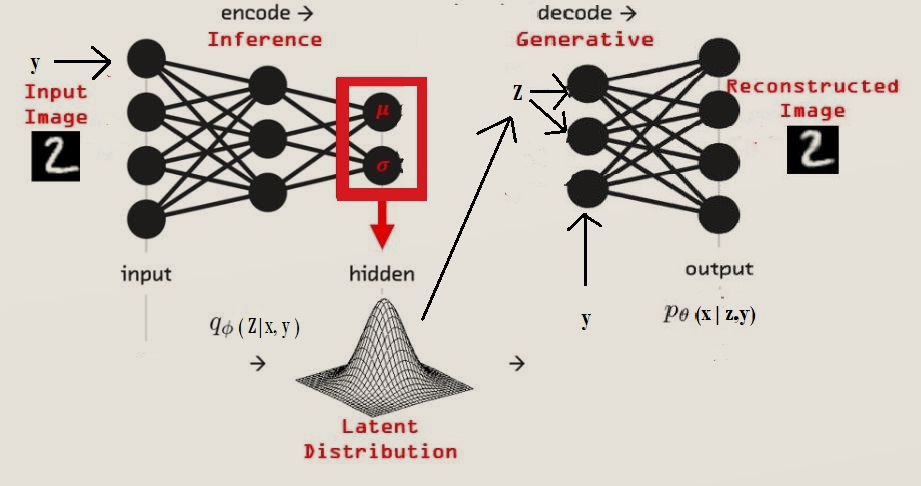



---



# Introduction and theory

"*The CVAE is a conditional
directed graphical model whose input observations modulate the prior on Gaussian latent variables
that generate the outputs. It is trained to maximize the conditional log-likelihood, and we formulate
the variational learning objective of the CVAE in the framework of stochastic gradient variational
Bayes (SGVB) [16].* "

### The CVAE loss function

The Conditional Variational Autoencoder (CVAE) loss function is defined as:

$$
\mathcal{L}(x, y; \theta, \phi) = \mathbb{E}_{q_{\phi}(z|x,y)}[\log p_{\theta}(y|x,z)] - \text{KL}(q_{\phi}(z|x,y) \parallel p_{\theta}(z|x))
$$

We will in this notebook use the β-weighted KL divergence to further explore the unfluence of the KL divergence

CVAE loss function ith β-weighted KL divergence:
$$
L(x, y; \theta, \phi) = \mathbb{E}_{q_{\phi}(z|x,y)} \left[ \log p_{\theta}(y|x,z) \right] - \beta \cdot \text{KL} \left( q_{\phi}(z|x,y) \parallel p_{\theta}(z|x) \right)
$$


Where:
- $x$ is the input data,
- $y$ is the conditional target data,
- $q_{\phi}(z|x,y)$ is the encoder (approximate posterior),
- $p_{\theta}(y|x,z)$ is the decoder (likelihood),
- $p_{\theta}(z|x)$ is the prior distribution,
- β controls the weight of the KL divergence term in the loss function.
- and $\text{KL}$ is the Kullback-Leibler divergence.


The Loss function contains two key components: the reconstruction loss and the Kullback-Leibler (KL) divergence.

* The reconstruction loss ensures the accuracy of the outpt "y" form the input "x" and the latent space "z". It ensures that the loss function is sensitive enough.

* The KL Divergence on the other hand ensures that the loss function is insensitive enough. It regularizes the latent space, ensuring that the posterior distribution (the distribution of latent variables learned from the data) is close to the prior distribution (the simple, predefined distribution), preventing overfitting and encouraging generalization. We want the posterior to not stray too far from the prior.

In addition the beta parameter controls the trade-off between reconstruction accuracy and the regularization of the latent space. A higher β places more importance on regularization, while a lower β prioritizes reconstruction.

## CVAE vs VAE


### Loss function

The loss function used in a traditional variational eutoencoder (VAE) is :
$$
L(x; \theta, \phi) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - \text{KL}(q_\phi(z|x) \parallel p_\theta(z))
$$

As the name says, and as we have seen the CVAE adds a conditioning on the input.
* In VAE, the loss function is based solely on the input data x, where the encoder $qϕ(z∣x)$ and the decoder $pθ(x∣z)$ are both conditioned on x.
* In CVAE, both the encoder and decoder are conditioned on both the input x **and the additional condition y**. The encoder $qϕ(z∣x,y)$ and the decoder $pθ(x∣z,y)$ take y into account, making the model capable of conditional generation.

### Conditional generation

As mentioned above using a CVAE alows conditional generation. Lets look at the difference this makes whan comparing to a traditional VAE.

* Without conditioning (VAE): The model learns to generate random images based on the overall distribution of all the clothing types, without any control over which specific clothing type is generated.

* With conditioning (CVAE): The model takes a condition (e.g., a label for the clothing type) as an additional input. Now, you can specify the type of clothing you want the model to generate (e.g., "generate a pair of shoes"). The model will then generate data (images) based on the condition you provide.

# Implementing the Conditional Variational Autoencoder (CVAE)

The following work is based on the practical work done during the HDDL course (in particular the vae notebook) but adding the conditional dimension and additional explorations.

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Loading the train and test dataset

In [16]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


## Visualizing a Batch of Fashion-MNIST Images

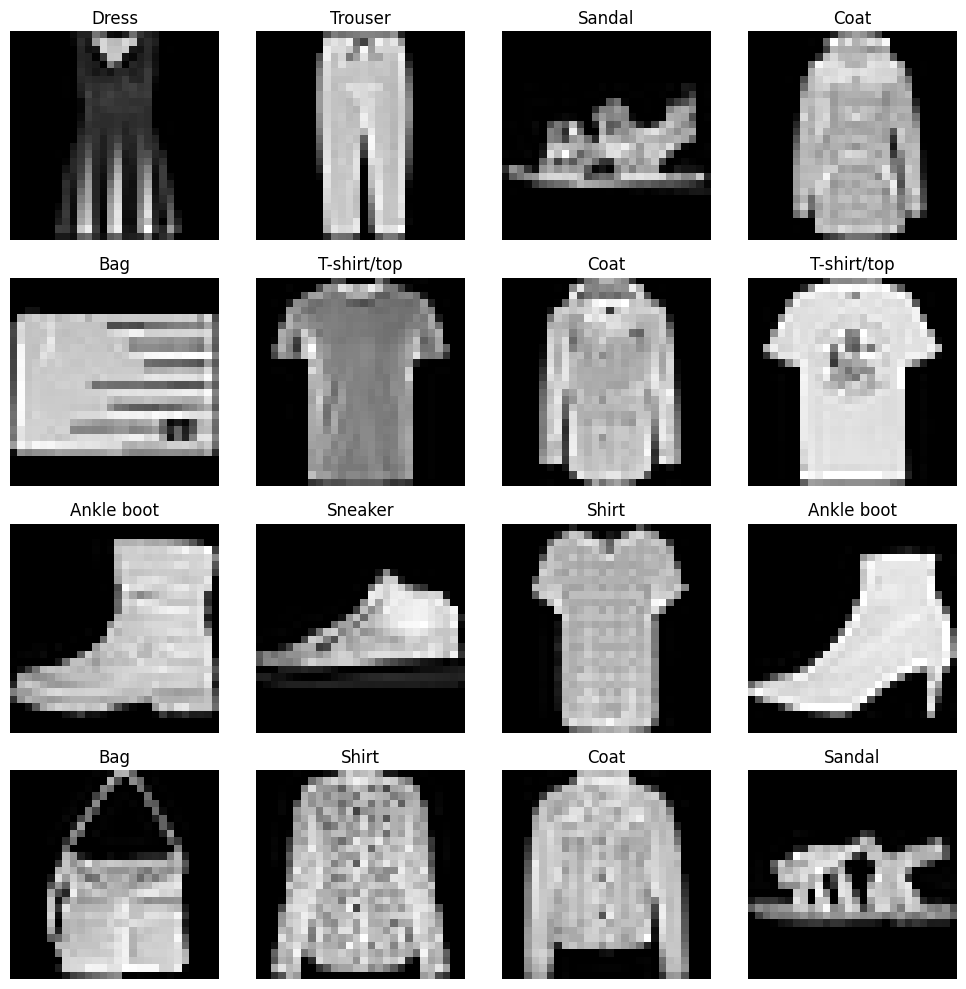

In [33]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Plot the batch of images
plt.figure(figsize=(10, 10))
for i in range(batch_size):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

## The CVAE model

### The encoder:

* Consist of three convolutional layers from which it learns spatial features. Each convolutional layer reduces the spatial dimensions of the input image while increasing the depth of the feature maps.

* After each convolutional layer we do a batch normalization. The batch normalization normalizes the inputs to each layer, ensuring that they have a consistent mean and variance across batches. This step helps stabilize and accelerate the training process.

* The ReLU activation function is used throughout the encoder and decoder. This function helps avoid the vanishing gradient problem and facilitates easier computations by setting negative values to zero, effectively deactivating those neurons.

### Fully Connected Layers for Latent Space
 * After the convolutional layers, the model flattens the feature map into a vector of size 128×4×4 (i.e., a flattened 128-channel 4x4 feature map). This vector is concatenated with the condition vector (the class label, one-hot encoded) to create the input for the fully connected layers. This conditioning allows the model to generate class-specific samples during decoding.

 * The network outputs two values: the mean (fc_mu) and the log variance (fc_logvar). The encoder takes in the input data and its associated condition (like the label) to generate these values. These mean and log variance values define a Gaussian distribution, from which we sample the latent vector z during training, using the reparameterization trick.



### The decoder:

Just like the encoder, the decoder also consists of three convolutional layers, batch normalization, and uses the ReLU activation function. However, there are some important differences:

* The decoder uses ConvTranspose2d (deconvolutional layers) instead of Conv2d (convolution layers). The deconvolution layers increase the spatial dimensions instead of reducing them, which allows us to rebuild a reconstructed image from the latent representation.

* For the last layer of the decoder, a Sigmoid activation function is used to produce pixel values between 0 and 1 for the output image.  

In [26]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=10, condition_dim=10 ):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim #ADDED

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance, ADDING the conditional dimension to the input
        self.fc_mu = nn.Linear(128 * 4 * 4 + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4 + condition_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + condition_dim, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )


    def encode(self, x, c ): # q(z|x, c)
        x = self.encoder(x)
        """ print("encode")
        print(np.shape(x))
        print(np.shape(c))  """
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers

        x = torch.cat([x, c], dim=1) # ADDED

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    """ def encode(self, x, y):
        print("encode")
        print(np.shape(x))
        print(np.shape(y))
        xc = torch.cat([x.view(-1, 28*28), y], dim=1)
        hidden = self.encoder(xc)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar
     """

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c ): # p(x|z, c)
        """ print("decode")
        print(np.shape(z))
        print(np.shape(c)) """
        z = torch.cat([z, c], dim=1) # ADDED

        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.sample(mu, logvar)
        return self.decode(z, c), mu, logvar

# CVAE loss function

In [6]:
# Implement the loss function
def loss_function_cvae(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

# Train the CVAE

To train the CVAE model, we need to find the best set of hyperparameters. To do this, we'll use grid search to try out different combinations of hyperparameters. This method helps us systematically explore the possibilities. Once we've trained the model with each combination, we'll evaluate its performance on the test set and pick the hyperparameters that result in the lowest test loss. This approach ensures we're selecting the optimal configuration for the model without the complexity of cross-validation.

In [20]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import itertools
from torch.utils.data import DataLoader


# Hyperparameter Grid
param_grid = {
    'latent_dim': [10, 20, 30],  # Latent space dimensions
    'learning_rate': [1e-3, 1e-4],  # Learning rate for optimizer
    'beta': [0.5, 1, 2],  # Weight for KL divergence
}

batch_size = 128
epochs = 5  # Reduced epochs for faster testing
condition_dim = 10  # Number of classes (10 for Fashion-MNIST)

# Load the dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

# Data Loaders for train and test
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid.values()))
best_params = None
lowest_test_loss = float('inf')

# Grid Search Loop
print(f"Total hyperparameter combinations: {len(param_combinations)}")

for idx, params in enumerate(param_combinations):
    latent_dim, learning_rate, beta = params
    print(f"\nTesting combination {idx + 1}/{len(param_combinations)}:")
    print(f"latent_dim={latent_dim}, condition_dim={condition_dim}, learning_rate={learning_rate}, beta={beta}, epochs={epochs}")

    # Model and optimizer
    cvae = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(1, epochs + 1):
        # Training Phase
        cvae.train()
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)
            c = F.one_hot(labels, num_classes=condition_dim).float()

            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data, c)
            loss, _, _ = loss_function_cvae(recon_batch, data, mu, logvar, beta)
            loss.backward()
            optimizer.step()

    # Validation Phase (on the test set, since you asked for no validation split)
    cvae.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            c = F.one_hot(labels, num_classes=condition_dim).float()

            recon_batch, mu, logvar = cvae(data, c)
            loss, _, _ = loss_function_cvae(recon_batch, data, mu, logvar, beta)
            test_loss += loss.item()

    # Average test loss
    test_loss /= len(test_loader.dataset)

    # Track the best hyperparameter combination based on test loss
    if test_loss < lowest_test_loss:
        lowest_test_loss = test_loss
        best_params = {
            'latent_dim': latent_dim,
            'condition_dim': condition_dim,
            'learning_rate': learning_rate,
            'beta': beta,
            'epochs': epochs,
        }

print("\nGrid Search Complete!")
print(f"Best Hyperparameters: {best_params}")
print(f"Lowest Test Loss: {lowest_test_loss:.4f}")



Total hyperparameter combinations: 18

Testing combination 1/18:
latent_dim=10, condition_dim=10, learning_rate=0.001, beta=0.5, epochs=5

Testing combination 2/18:
latent_dim=10, condition_dim=10, learning_rate=0.001, beta=1, epochs=5

Testing combination 3/18:
latent_dim=10, condition_dim=10, learning_rate=0.001, beta=2, epochs=5

Testing combination 4/18:
latent_dim=10, condition_dim=10, learning_rate=0.0001, beta=0.5, epochs=5

Testing combination 5/18:
latent_dim=10, condition_dim=10, learning_rate=0.0001, beta=1, epochs=5

Testing combination 6/18:
latent_dim=10, condition_dim=10, learning_rate=0.0001, beta=2, epochs=5

Testing combination 7/18:
latent_dim=20, condition_dim=10, learning_rate=0.001, beta=0.5, epochs=5

Testing combination 8/18:
latent_dim=20, condition_dim=10, learning_rate=0.001, beta=1, epochs=5

Testing combination 9/18:
latent_dim=20, condition_dim=10, learning_rate=0.001, beta=2, epochs=5

Testing combination 10/18:
latent_dim=20, condition_dim=10, learning_r

**Outputs only using one epoch:**

Best Hyperparameters: {'latent_dim': 20, 'condition_dim': 10, 'learning_rate': 0.001, 'beta': 0.5, 'epochs': 1}

Lowest Test Loss: 239.4686



**Outputs using five epoch:**

Best Hyperparameters: {'latent_dim': 20, 'condition_dim': 10, 'learning_rate': 0.001, 'beta': 0.5, 'epochs': 5}

Lowest Test Loss: 231.8222


## Training the model with optimized hyperparameters

Since increasing the number of epochs impoves the loss of the model we will use 30 epochs when training the final model, as well as using the hyperparameters found in the grid search.

In [7]:
# Hyperparameters
latent_dim = 20
condition_dim = 10 ###
learning_rate = 1e-3
epochs = 30 #30
beta = 0.5 #1

epoch_loss_list=[]

cvae = CVAE(latent_dim=latent_dim, condition_dim= condition_dim)
#print(cvae)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0

    for batch_idx, (data, labels) in enumerate(train_loader):  # Assuming labels is the class label

        data = data.to(device)
        labels = labels.to(device)

        # Convert labels to one-hot encoding for the condition vector `c`
        c = F.one_hot(labels, num_classes=condition_dim).float()  # One-hot encoded condition vector

        optimizer.zero_grad()

        # print(np.shape(data))

        recon_batch, mu, logvar = cvae(data, c)

        loss,_,_ = loss_function_cvae(recon_batch, data, mu, logvar, beta) # using the CVAE loss function

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_loss_list.append(epoch_loss)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 254.0758
Epoch 2, Training loss: 243.4279
Epoch 3, Training loss: 240.9211
Epoch 4, Training loss: 239.5553
Epoch 5, Training loss: 238.5611
Epoch 6, Training loss: 237.8579
Epoch 7, Training loss: 237.3445
Epoch 8, Training loss: 236.9130
Epoch 9, Training loss: 236.6159
Epoch 10, Training loss: 236.2422
Epoch 11, Training loss: 235.9747
Epoch 12, Training loss: 235.7987
Epoch 13, Training loss: 235.6277
Epoch 14, Training loss: 235.4307
Epoch 15, Training loss: 235.3195
Epoch 16, Training loss: 235.1708
Epoch 17, Training loss: 235.0535
Epoch 18, Training loss: 234.9695
Epoch 19, Training loss: 234.7916
Epoch 20, Training loss: 234.7313
Epoch 21, Training loss: 234.6312
Epoch 22, Training loss: 234.5497
Epoch 23, Training loss: 234.4449
Epoch 24, Training loss: 234.4144
Epoch 25, Training loss: 234.3315
Epoch 26, Training loss: 234.2027
Epoch 27, Training loss: 234.2025
Epoch 28, Training loss: 234.1379
Epoch 29, Training loss: 234.0502
Epoch 30, Training loss

Training and tracking and plotting the loss terms

Epoch 1, Loss: 257.1710, Recon: 245.2757, KL: 23.7905
Epoch 2, Loss: 235.6767, Recon: 223.6860, KL: 23.9814
Epoch 3, Loss: 233.0056, Recon: 221.1187, KL: 23.7738
Epoch 4, Loss: 231.4319, Recon: 219.6697, KL: 23.5246
Epoch 5, Loss: 230.4378, Recon: 218.7916, KL: 23.2923
Epoch 6, Loss: 229.6225, Recon: 218.0675, KL: 23.1099
Epoch 7, Loss: 229.1330, Recon: 217.6520, KL: 22.9619
Epoch 8, Loss: 228.6785, Recon: 217.2674, KL: 22.8221
Epoch 9, Loss: 228.2119, Recon: 216.8761, KL: 22.6715
Epoch 10, Loss: 227.8020, Recon: 216.5255, KL: 22.5531
Epoch 11, Loss: 227.5023, Recon: 216.2563, KL: 22.4919
Epoch 12, Loss: 227.3064, Recon: 216.0968, KL: 22.4192
Epoch 13, Loss: 226.9966, Recon: 215.8349, KL: 22.3233
Epoch 14, Loss: 226.8768, Recon: 215.7485, KL: 22.2567
Epoch 15, Loss: 226.6444, Recon: 215.5515, KL: 22.1857
Epoch 16, Loss: 226.4403, Recon: 215.3646, KL: 22.1513
Epoch 17, Loss: 226.2757, Recon: 215.2447, KL: 22.0618
Epoch 18, Loss: 226.1653, Recon: 215.1477, KL: 22.0353
Epoch 19, Loss: 225

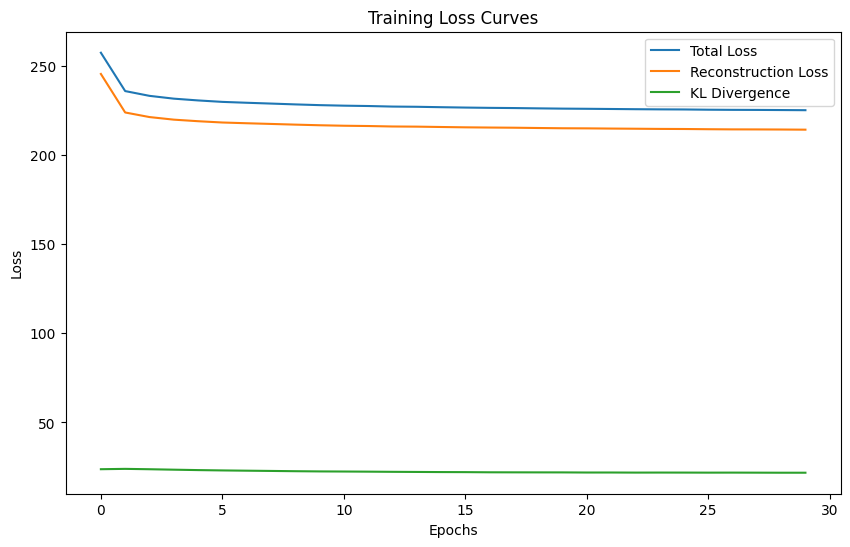

In [32]:
# Hyperparameters
latent_dim = 20
condition_dim = 10
learning_rate = 1e-3
epochs = 30 #30
beta = 0.5 #1

batch_size = 128

# Initialize variables for tracking loss terms
reconstruction_losses = []
kl_divergence_losses = []
total_losses = []

# Create the model and optimizer
cvae = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Training loop
for epoch in range(1, epochs + 1):
    cvae.train()
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    running_total_loss = 0.0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        c = F.one_hot(labels, num_classes=condition_dim).float()  # One-hot encoding for condition vector

        optimizer.zero_grad()

        recon_batch, mu, logvar = cvae(data, c)

        # Get loss values: total, reconstruction, and KL divergence
        loss, recon_loss, kl_loss = loss_function_cvae(recon_batch, data, mu, logvar, beta)

        loss.backward()
        optimizer.step()

        # Accumulate losses
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
        running_total_loss += loss.item()

    # Average the loss terms over the dataset for the epoch
    epoch_recon_loss = running_recon_loss / len(train_loader.dataset)
    epoch_kl_loss = running_kl_loss / len(train_loader.dataset)
    epoch_total_loss = running_total_loss / len(train_loader.dataset)

    # Store the losses for later plotting
    reconstruction_losses.append(epoch_recon_loss)
    kl_divergence_losses.append(epoch_kl_loss)
    total_losses.append(epoch_total_loss)

    print(f"Epoch {epoch}, Loss: {epoch_total_loss:.4f}, Recon: {epoch_recon_loss:.4f}, KL: {epoch_kl_loss:.4f}")

# Plot Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(total_losses, label="Total Loss")
plt.plot(reconstruction_losses, label="Reconstruction Loss")
plt.plot(kl_divergence_losses, label="KL Divergence")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()


# Visulaisation

Using the function provided from the course we can now plot the results.

In [34]:
import matplotlib.pyplot as plt

def image_comparison(original_images, reconstructions, n_images=6):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(2, n_images, figsize=(10, 5))

    for i in range(n_images):
        # Plot original images
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

        # Reconstructed images
        ax[1, i].imshow(reconstructions[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, 0].set_title('Recomstruction')

    plt.tight_layout()
    plt.show()

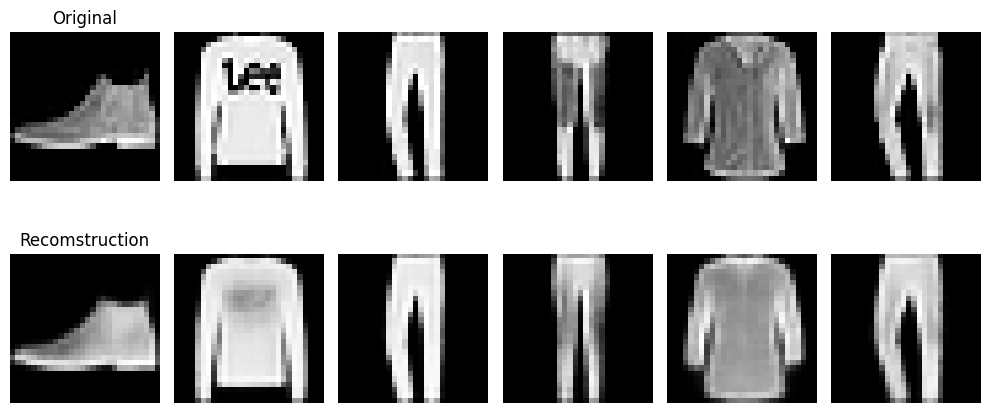

In [35]:
# Select a batch of images from the test dataset
random_images, labels = next(iter(test_loader))

# One-hot encode the labels for the conditional input
c = F.one_hot(labels, num_classes=condition_dim).float().to(device)  # Convert labels to one-hot encoding

# Get the reconstructions of the selected images
recons, _, _ = cvae(random_images.to(device), c)  # Pass entire batch of images and conditional labels

# Reshape the images for plotting
random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)

# Generating 5 new samples

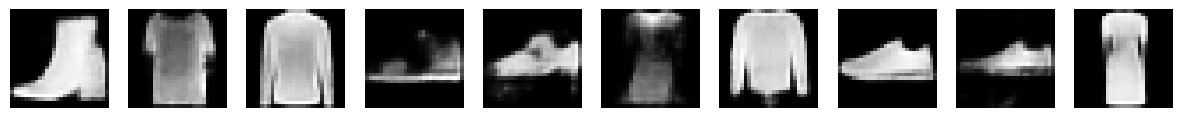

In [36]:
def generate_sample(num_samples=10):
    cvae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample random latent vectors

        random_labels = torch.randint(0, condition_dim, (num_samples,)).to(device)  # Random class labels
        c = F.one_hot(random_labels, num_classes=condition_dim).float().to(device)  # One-hot encode labels

        samples = cvae.decode(z,c) # Decode the latent vectors
        samples = samples.cpu().view(num_samples, 1, 28, 28) # Reshape the samples

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

generate_sample()

Unlike a normal VAE, the CVAE allows us to generate samples from specific classes. In this case, we will plot five generated samples from each class by sampling from the latent space and decoding the images.

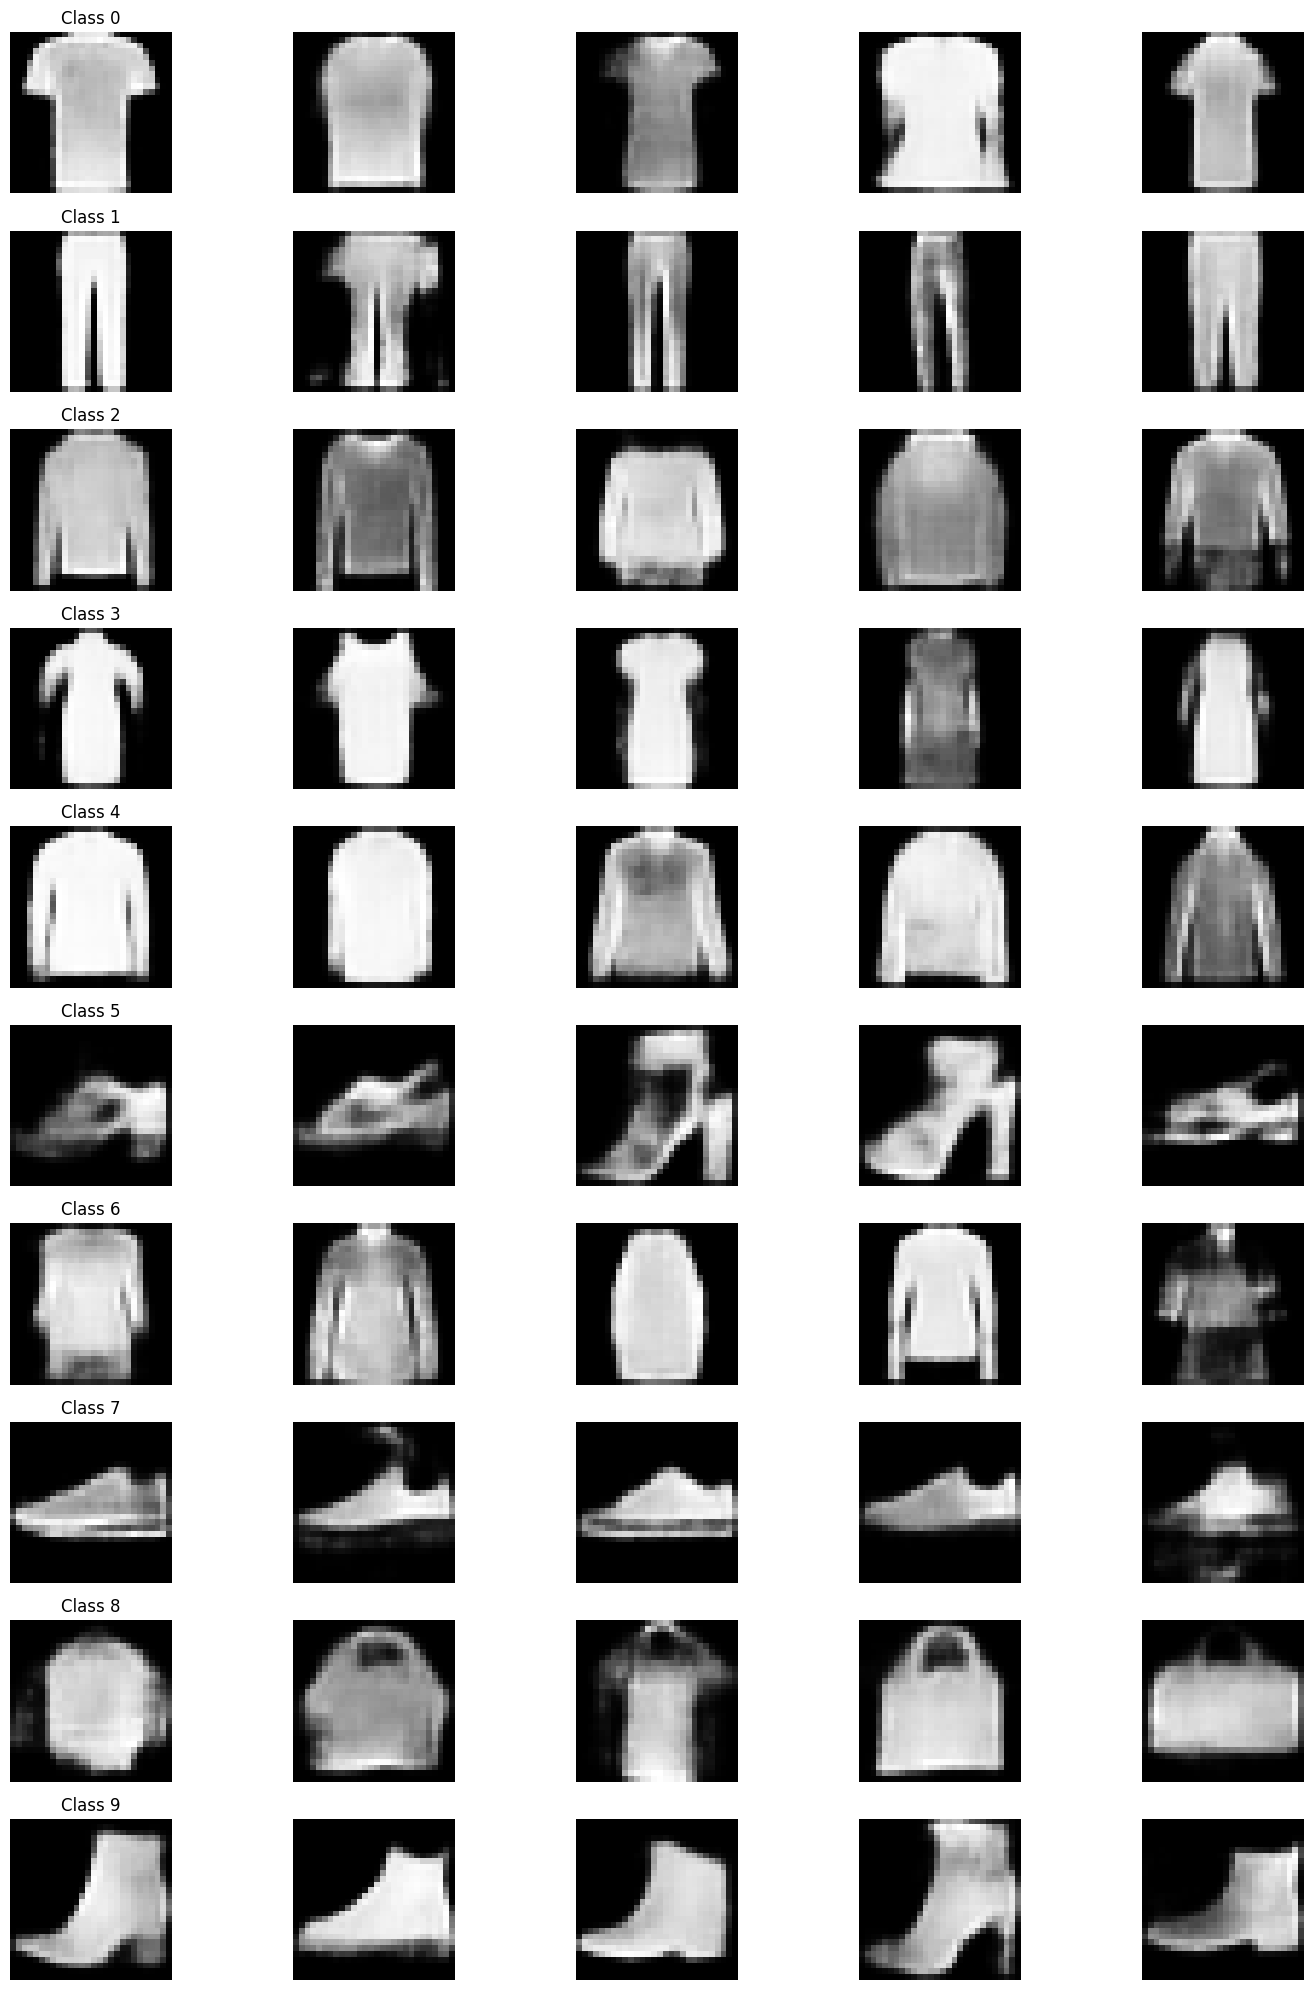

In [37]:
def generate_sample_per_class(num_samples_per_class=5):
    cvae.eval()
    with torch.no_grad():
        fig, ax = plt.subplots(condition_dim, num_samples_per_class, figsize=(15, 2 * condition_dim))

        for class_idx in range(condition_dim):
            z = torch.randn(num_samples_per_class, latent_dim).to(device)  # Sample random latent vectors
            c = F.one_hot(torch.full((num_samples_per_class,), class_idx), num_classes=condition_dim).float().to(device)  # One-hot encode class label

            samples = cvae.decode(z, c)  # Decode the latent vectors
            samples = samples.cpu().view(num_samples_per_class, 1, 28, 28)  # Reshape the samples

            for i in range(num_samples_per_class):
                ax[class_idx, i].imshow(samples[i].squeeze(0), cmap='gray')
                ax[class_idx, i].axis('off')
                ax[class_idx, i].set_title(f'Class {class_idx}' if i == 0 else "")

        plt.tight_layout()
        plt.show()

# Call the function to generate samples
generate_sample_per_class(num_samples_per_class=5)


## Visualizing the latent space


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 253.5971, BCE: 239.2655, KLD: 14.3316
Epoch 2: Average Loss: 243.1360, BCE: 229.0766, KLD: 14.0594
Epoch 3: Average Loss: 240.6787, BCE: 226.7053, KLD: 13.9734
Epoch 4: Average Loss: 239.3161, BCE: 225.3586, KLD: 13.9575
Epoch 5: Average Loss: 238.4183, BCE: 224.5152, KLD: 13.9031
Epoch 6: Average Loss: 237.7509, BCE: 223.8343, KLD: 13.9166
Epoch 7: Average Loss: 237.2492, BCE: 223.3659, KLD: 13.8834
Epoch 8: Average Loss: 236.8258, BCE: 222.9237, KLD: 13.9021
Epoch 9: Average Loss: 236.4608, BCE: 222.5654, KLD: 13.8954
Epoch 10: Average Loss: 236.2020, BCE: 222.3236, KLD: 13.8784
Epoch 11: Average Loss: 235.9639, BCE: 222.0831, KLD: 13.8808
Epoch 12: Average Loss: 235.7227, BCE: 221.8762, KLD: 13.8465
Epoch 13: Average Loss: 235.5276, BCE: 221.6418, KLD: 13.8858
Epoch 14: Average Loss: 235.3109, BCE: 221.4493, KLD: 13.8616
Epoch 15: Average Loss: 235.1453, BCE: 221.3096, KLD: 13.8357
Epoch 16: Average Loss: 235.0112, BCE: 221.170

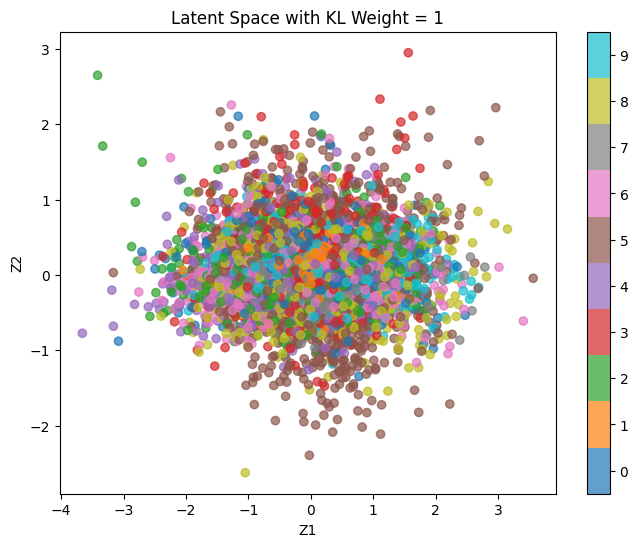


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 294.5880, BCE: 278.1143, KLD: 1.6474
Epoch 2: Average Loss: 283.6737, BCE: 265.6870, KLD: 1.7987
Epoch 3: Average Loss: 281.4017, BCE: 262.8149, KLD: 1.8587
Epoch 4: Average Loss: 280.2212, BCE: 261.2376, KLD: 1.8984
Epoch 5: Average Loss: 279.6312, BCE: 260.3625, KLD: 1.9269
Epoch 6: Average Loss: 279.1413, BCE: 259.5891, KLD: 1.9552
Epoch 7: Average Loss: 278.6558, BCE: 259.0603, KLD: 1.9595
Epoch 8: Average Loss: 278.3700, BCE: 258.5498, KLD: 1.9820
Epoch 9: Average Loss: 278.1073, BCE: 258.1984, KLD: 1.9909
Epoch 10: Average Loss: 277.9622, BCE: 257.8739, KLD: 2.0088
Epoch 11: Average Loss: 277.8751, BCE: 257.7174, KLD: 2.0158
Epoch 12: Average Loss: 277.5410, BCE: 257.3568, KLD: 2.0184
Epoch 13: Average Loss: 277.4029, BCE: 257.1779, KLD: 2.0225
Epoch 14: Average Loss: 277.3583, BCE: 257.0965, KLD: 2.0262
Epoch 15: Average Loss: 277.3054, BCE: 256.8594, KLD: 2.0446
Epoch 16: Average Loss: 277.0754, BCE: 256.6783, KLD: 2.0397

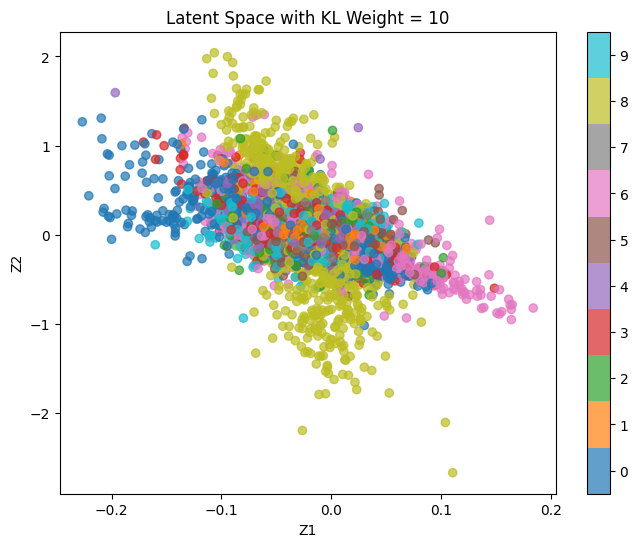


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 316.2317, BCE: 313.1516, KLD: 0.0308
Epoch 2: Average Loss: 308.7759, BCE: 308.5239, KLD: 0.0025
Epoch 3: Average Loss: 308.1955, BCE: 308.1034, KLD: 0.0009
Epoch 4: Average Loss: 307.9291, BCE: 307.8599, KLD: 0.0007
Epoch 5: Average Loss: 307.7649, BCE: 307.7105, KLD: 0.0005
Epoch 6: Average Loss: 307.6889, BCE: 307.6497, KLD: 0.0004
Epoch 7: Average Loss: 307.6320, BCE: 307.5936, KLD: 0.0004
Epoch 8: Average Loss: 307.5500, BCE: 307.5164, KLD: 0.0003
Epoch 9: Average Loss: 307.5072, BCE: 307.4764, KLD: 0.0003
Epoch 10: Average Loss: 307.5048, BCE: 307.4763, KLD: 0.0003
Epoch 11: Average Loss: 307.4622, BCE: 307.4398, KLD: 0.0002
Epoch 12: Average Loss: 307.4333, BCE: 307.4111, KLD: 0.0002
Epoch 13: Average Loss: 307.4294, BCE: 307.4098, KLD: 0.0002
Epoch 14: Average Loss: 307.3866, BCE: 307.3638, KLD: 0.0002
Epoch 15: Average Loss: 307.3824, BCE: 307.3627, KLD: 0.0002
Epoch 16: Average Loss: 307.3872, BCE: 307.3718, KLD: 0.000

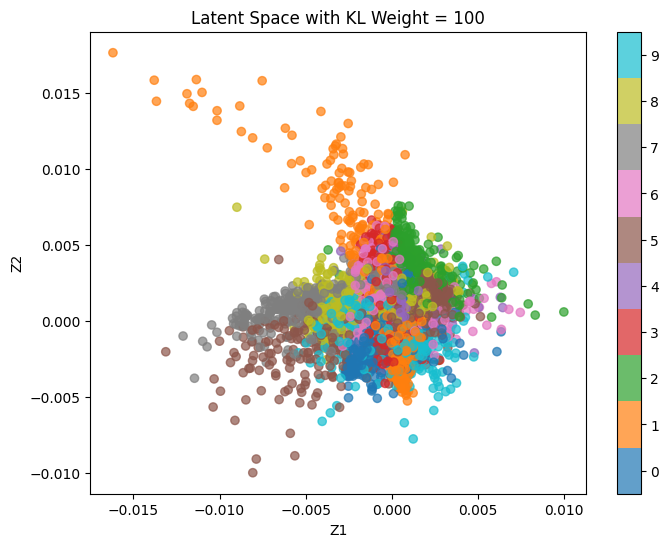

In [38]:
# Hyperparameters
latent_dims = 20
condition_dim = 10 ###
batch_size = 128
num_epochs = 30
learning_rate = 1e-3
kl_weights = [1, 10, 100]  # Different weights for the KL divergence term

# Training and plotting function
def train_and_plot(kl_weight):
    model = CVAE(latent_dims, condition_dim).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):  # Assuming labels is the class label

            data = data.to(device)
            labels = labels.to(device)

            # Convert labels to one-hot encoding for the condition vector `c`
            c = F.one_hot(labels, num_classes=condition_dim).float()  # One-hot encoded condition vector

            optimizer.zero_grad()

            # print(np.shape(data))

            recon_batch, mu, logvar = model(data, c)

            loss,bce,kld = loss_function_cvae(recon_batch, data, mu, logvar, kl_weight) # using the CVAE loss function

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()

        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')

    # Plot latent space
    plot_latent_space(model, kl_weight)

# Function to plot latent space
def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = labels.to(device)
        c = F.one_hot(labels, num_classes=condition_dim).float()  # One-hot encoded condition vector
        mu, logvar = model.encode(data,c)
        z = mu  # For visualization, we use the mean
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()

        plt.figure(figsize=(8,6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()

# Run training and plotting for different KL weights
for kl_weight in kl_weights:
    print(f'\nTraining CVAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)

Sources:

https://proceedings.neurips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf

https://pyro.ai/examples/cvae.html

https://beckham.nz/2023/04/27/conditional-vaes.html

https://www.shiksha.com/online-courses/articles/relu-and-sigmoid-activation-function/#ReLU
